<a href="https://colab.research.google.com/github/BhushanPawar-01/Violence_Detection/blob/main/violence_detection_by_Bhushan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# __Violence Detection__  
*by Bhushan Pawar*

---




In [ ]:
# Importing dataset directly from kaggle
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'real-life-violence-situations-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F176381%2F397693%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240319%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240319T055338Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D399dffc174b06055c1be5f278c4d90222ac582931c993df2fe68ff064647415d426ca2f364779cbb4af3fd6b62b433d25e03099b02400cee4abb8242bcf25e99f2a0251d699da2dacedee4623d3a3c108081a0b06c44e355654900bfc0fc69dc9bb206003528a7299478bf546faca7240c2d08fd754a94749dbb03e4165b9cc29a101749f24ffadcc4c6ed0cb707acd28defcd6867807349d3fedb2a9f5ffc5b9591ccf576469caf9d4c60f757da285334f030926da668023cc743fc07e16085fa8eb2d31bb8590e70f1a9992e7e1a9840a75348d502fce8fd395269420573022c5ed8475b1ee4ade88003bfaf822a6d04e734fb1b562dcfdda93ac3206f9528'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3847870446 bytes downloaded
Downloaded and uncompressed: real-life-violence-situations-dataset
Data source import complete.




---


__Importing Important Libraries__

In [ ]:
import shutil
import cv2
import math
import random
import os
import sys
import numpy as np
import datetime as dt
from collections import deque
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("seaborn")
%matplotlib inline

<ipython-input-2-88879d7e7b22>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [ ]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, BatchNormalization

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix



---


**Video Processing and Dataset Creation**




In [ ]:
# Class directories
Non_Violence_Videos_Dir = '../input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence/'
Violence_Videos_Dir = '../input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence/'

# Retrieving list of all video files in a class directory
NonViolence_files_names_list = os.listdir(Non_Violence_Videos_Dir)
Violence_files_names_list = os.listdir(Violence_Videos_Dir)

# Randomly select video files from class directory
Random_NonViolence_Video = random.choice(NonViolence_files_names_list[:500])
Random_Violence_Video = random.choice(Violence_files_names_list[:500])

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 16

DATASET_DIR = '../input/real-life-violence-situations-dataset/Real Life Violence Dataset/'

CLASSES_LIST = ['NonViolence', 'Violence']

In [ ]:
# The frame_extraction function performs frame extraction from a video file,
# resizing and normalizing each frame before appending it to the frames list.

def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
# The create_dataset function generates a dataset by extracting frames from
# video files, matching them to a predefined sequence length, and organizing
# them with corresponding labels and file paths.

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths


In [ ]:
# Creating dataset
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: NonViolence
Extracting Data of Class: Violence


In [ ]:
# Save the features, labels, and video_files_path,
#this are stored only for current session but can be downloaded to use in future.

np.save('features.npy', features)
np.save('labels.npy', labels)
np.save('video_files_paths.npy', video_files_paths)



---


**Data Preprocessing**

In [ ]:
# Load dataset
features = np.load('features.npy')
labels = np.load('labels.npy')
video_files_paths = np.load('video_files_paths.npy')

In [ ]:
# Perform one hot encoding on labels
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
# Perform train test split
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.1,
                                                                            shuffle=True, random_state=42)

In [ ]:
print(features_train.shape, labels_train.shape)
print(features_test.shape, labels_test.shape)

(1800, 16, 64, 64, 3) (1800, 2)
(200, 16, 64, 64, 3) (200, 2)




---
**Model Building**


In [ ]:
CLASSES_LIST = ['NonViolence', 'Violence']

In [ ]:

def create_model(input_shape=(16, 64, 64, 3)):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Feature Extraction Layers
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

    model.add(TimeDistributed(Dropout(0.25)))
    model.add(TimeDistributed(Flatten()))

    # Layers responsible for classification
    lstm_fw = LSTM(units=32, return_sequences=True)
    lstm_bw = LSTM(units=32, go_backwards=True, return_sequences=True)
    model.add(Bidirectional(lstm_fw, backward_layer=lstm_bw))

    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(GlobalAveragePooling1D())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))

    return model

In [ ]:
# Initialize the model
model = create_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 64, 64, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 64, 64, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 16, 32, 32, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 16, 32, 32, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 16, 32, 32, 64)    2

In [ ]:
# Initialize the early stoping with appropriate hyperparameters
early_stopping = EarlyStopping(monitor='val_accuracy',
                                        patience=10, restore_best_weights=True)


In [ ]:
# Initialize the ReduceLROnPlateau, it will reduce learning rate if model learning remains constant for given epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.6, patience=5, min_lr=0.00005, verbose=1)

In [ ]:
# Model comilation
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])

In [ ]:
# Model training and validation
model_history = model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                             shuffle=True, validation_split=0.2,
                                             callbacks=[early_stopping, reduce_lr])

Epoch 1/50
180/180 [==============================] - 19s 48ms/step - loss: 0.6096 - accuracy: 0.6847 - val_loss: 0.6888 - val_accuracy: 0.5611 - lr: 0.0100
Epoch 2/50
180/180 [==============================] - 7s 39ms/step - loss: 0.4491 - accuracy: 0.7958 - val_loss: 0.6258 - val_accuracy: 0.6278 - lr: 0.0100
Epoch 3/50
180/180 [==============================] - 7s 38ms/step - loss: 0.3806 - accuracy: 0.8278 - val_loss: 0.7968 - val_accuracy: 0.5944 - lr: 0.0100
Epoch 4/50
180/180 [==============================] - 7s 39ms/step - loss: 0.3030 - accuracy: 0.8660 - val_loss: 0.3448 - val_accuracy: 0.8556 - lr: 0.0100
Epoch 5/50
180/180 [==============================] - 7s 39ms/step - loss: 0.2498 - accuracy: 0.8986 - val_loss: 0.3643 - val_accuracy: 0.8389 - lr: 0.0100
Epoch 6/50
180/180 [==============================] - 7s 38ms/step - loss: 0.1948 - accuracy: 0.9167 - val_loss: 0.3485 - val_accuracy: 0.8556 - lr: 0.0100
Epoch 7/50
180/180 [==============================] - 7s 39ms/s

---

**Evaluating and Analysing Performance of Model on Test Data**




In [ ]:
# Evaluate model on test dataset

predicted_labels = model.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1)
original_labels = np.argmax(labels_test, axis=1)

7/7 [==============================] - 3s 30ms/step


[Text(0, 0.5, 'NonViolence'), Text(0, 1.5, 'Violence')]

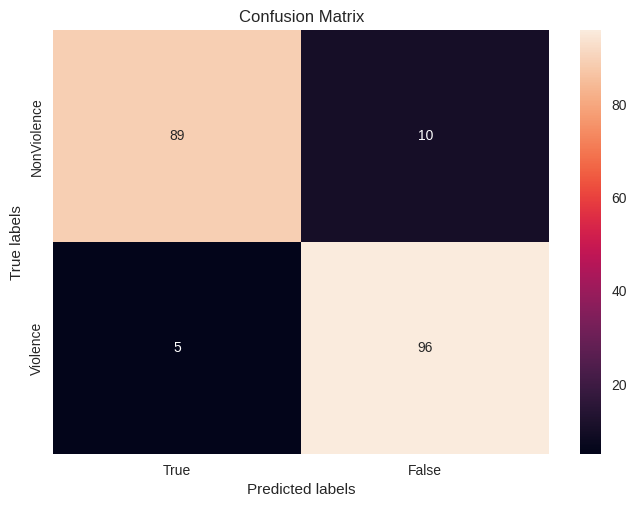

In [ ]:
# Create confusion matrix for test data predictions

ax = plt.subplot()
cm = confusion_matrix(original_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['NonViolence', 'Violence'])

In [ ]:
# Generate classfication report for the test data

Classification_Report = classification_report(original_labels, predicted_labels)
print('Classification Report is : \n', Classification_Report)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92        99
           1       0.92      0.93      0.93       101

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200

